In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import shap
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
save_plots = False
save_model = True
use_monthly_and_weekly_avg = True

In [3]:
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
# bierzemy pod uwagę tylko te sesje, które zakończły się zakupem
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
# data z timestampu w celu późniejszego grupowania
buy_sessions['date']=buy_sessions['timestamp'].dt.date
# te wartości i tak by znikły przy grupowaniu
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
# grupujemy po dacie i ID produktu
df = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
# nie ma to w sumie wielkiego znaczenia, ale lepiej żeby było to stringiem - ID nie musi być liczbą
df['product_id'] = df['product_id'].astype(str)

In [4]:
# co prawda przedtem robiliśmy w drugą stronę, ale teraz musimy to zamienić z powrotem na timestamp żeby pd.Grouper działało
df['date'] = pd.to_datetime(df['date'])
# grupujemy w tygodnie
df=df.groupby(by=[pd.Grouper(key='date', freq='W'), pd.Grouper(key='product_id')]).sum()

In [5]:
df

amount
date       product_id        
2019-08-04 1002             3
           1003             0
           1004             0
           1005             0
           1006             1
...                       ...
2021-12-26 1310             0
           1311             0
           1312             0
           1313             0
           1314             0

[24822 rows x 1 columns]

In [6]:
products = pd.read_json("../data/raw/second/products.jsonl", lines=True)
del products['product_name']
products['product_id']=products['product_id'].astype(str)
products.index=products['product_id']
# dodajemy dane z products
df=df.join(products,on='product_id')

In [7]:
# stworzył nam się podwójny indeks przez grupowanie, więc usuńmy go, product_id i tak mamy z dataframe products
df.index = df.index.get_level_values(0)

In [8]:
df

,amount,product_id,category_path,price
date,,,,
2019-08-04,3,1002,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2019-08-04,0,1003,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
2019-08-04,0,1004,Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2019-08-04,0,1005,Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2019-08-04,1,1006,Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
...,...,...,...,...
2021-12-26,0,1310,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,79.99
2021-12-26,0,1311,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,189.99
2021-12-26,0,1312,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,99.90


In [9]:
# opakowane w funkcje w celu niedublowania kodu, tworzymy tutaj zmienne z daty oraz kodujemy OneHotEncodingiem category_path\
# jest to konieczne, gdyż XGBoost nie przyjmuje zmiennych kategorycznych
def create_features(df):
    df['date'] = df.index.get_level_values(0)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.week
    del df['date']
    df=pd.get_dummies(df,columns=['category_path'])
    return df

In [10]:
# tworzymy zbiór treningowy i testowy
split_date = pd.to_datetime('2021-09-01')
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [11]:
train=create_features(train)
test=create_features(test)

/tmp/ipykernel_47739/528954396.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.week


In [12]:
def merge(df1, df2, col,col_name):
    df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col, right_index=False, sort=True,
             copy=True, indicator=False)
    df1 = df1.rename(columns={'amount_y':col_name})
    return df1

In [13]:
if use_monthly_and_weekly_avg:
    train['monthly_avg'] = train.groupby(['product_id','month'])['amount'].transform('mean')
    train['weekly_avg'] = train.groupby(['product_id','weekofyear'])['amount'].transform('mean')

    monthly_avg = train.groupby(['product_id','month'])['amount'].mean().reset_index()
    weekly_avg = train.groupby(['product_id','weekofyear'])['amount'].mean().reset_index()

    test['copy_index'] = test.index

    test = merge(test, monthly_avg,['product_id','month'],'monthly_avg')
    test = test.rename(columns={'amount_x': 'amount'})

    test = merge(test, weekly_avg,['product_id','weekofyear'],'weekly_avg')
    test = test.rename(columns={'amount_x': 'amount'})

    test.index=test['copy_index']
    del test['copy_index']

In [14]:
monthly_avg, weekly_avg

(     product_id  month    amount
 0          1002      1  1.333333
 1          1002      2  0.000000
 2          1002      3  1.888889
 3          1002      4  0.000000
 4          1002      5  1.700000
 ...         ...    ...       ...
 2359       1314      8  0.000000
 2360       1314      9  0.000000
 2361       1314     10  0.000000
 2362       1314     11  0.000000
 2363       1314     12  0.111111
 
 [2364 rows x 3 columns],
       product_id  weekofyear  amount
 0           1002           1     0.5
 1           1002           2     5.5
 2           1002           3     0.0
 3           1002           4     0.0
 4           1002           5     0.0
 ...          ...         ...     ...
 10436       1314          49     0.0
 10437       1314          50     0.0
 10438       1314          51     0.5
 10439       1314          52     0.0
 10440       1314          53     0.0
 
 [10441 rows x 3 columns])

[Text(0.5, 0, 'amount'),
 Text(1.5, 0, 'price'),
 Text(2.5, 0, 'quarter'),
 Text(3.5, 0, 'month'),
 Text(4.5, 0, 'year'),
 Text(5.5, 0, 'weekofyear'),
 Text(6.5, 0, 'category_path_Gry i konsole;Gry komputerowe'),
 Text(7.5, 0, 'category_path_Gry i konsole;Gry na konsole;Gry PlayStation3'),
 Text(8.5, 0, 'category_path_Gry i konsole;Gry na konsole;Gry Xbox 360'),
 Text(9.5, 0, 'category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne'),
 Text(10.5, 0, 'category_path_Komputery;Monitory;Monitory LCD'),
 Text(11.5, 0, 'category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV'),
 Text(12.5, 0, 'monthly_avg'),
 Text(13.5, 0, 'weekly_avg')]

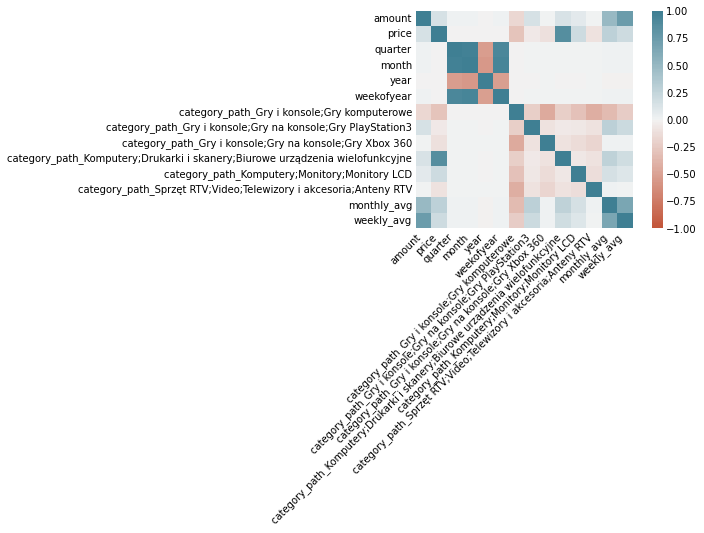

In [15]:
# Tworzymy macierz korelacji, należy jednak pamiętać, że bada korelacje liniowe - a w danych mogą występować również korelacje nieliniowe
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [16]:
# product_id jako int nie ma sensu, jako string nie może być w modelu, ma za dużą możliwość wartości
# żeby zastosować OneHotEncoding
del train['product_id']
del test['product_id']

In [17]:
X_train=train.drop('amount', axis=1)
y_train=train['amount']
              
X_test=test.drop('amount', axis=1)
y_test=test['amount']

In [18]:
import sys
sys.path.append('../')
from sales_forecasting.models.custom_xgboost import CustomXGBRegressor

# tworzymy model regresyjny XGBoost
if use_monthly_and_weekly_avg:
    reg = CustomXGBRegressor(n_estimators=10000, monthly_avg=monthly_avg, weekly_avg=weekly_avg)
else:
    reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

[20:22:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:576: 
Parameters: { "monthly_avg", "weekly_avg" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




CustomXGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                   colsample_bynode=1, colsample_bytree=1,
                   enable_categorical=False, gamma=0, gpu_id=-1,
                   importance_type=None, interaction_constraints='',
                   learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                   min_child_weight=1, missing=nan, monotone_constraints='()',
                   monthly_avg=     product_id  month    amount
0          1002...
4          1002      5  1.700000
...         ...    ...       ...
2359       1314      8  0.000000
2360       1314      9  0.000000
2361       1314     10  0.000000
2362       1314     11  0.000000
2363       1314     12  0.111111

[2364 rows x 3 columns],
                   n_estimators=10000, n_jobs=12, num_parallel_tree=1,
                   objective='reg:squarederror', predictor='auto',
                   random_state=0, reg_alpha=0, reg_lambda=1,
                   scale_pos_weight=1

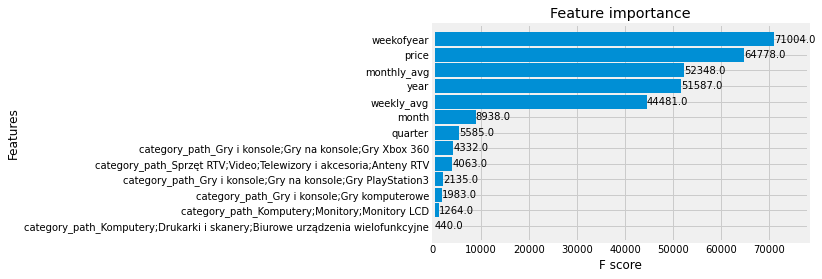

In [19]:
# tutaj 
_ = plot_importance(reg, height=0.9)

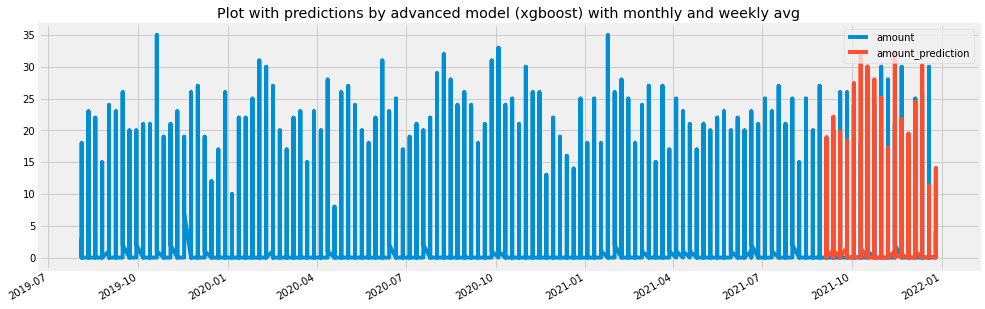

In [20]:
# zobaczmy jak to wygląda na wykresie
test['amount_prediction'] = reg.predict(X_test)
test['amount_prediction']=test['amount_prediction'].clip(lower=0)
df_all = pd.concat([train, test], sort=False)
title = 'Plot with predictions by advanced model (xgboost)'
if use_monthly_and_weekly_avg:
    title += ' with monthly and weekly avg'
_ = df_all[['amount','amount_prediction']].plot(figsize=(15, 5), title=title)
if save_plots:
    plot_file_title = 'xgboost_plot'
    if use_monthly_and_weekly_avg:
        plot_file_title += '_with_averages'
    plt.savefig(f'{plot_file_title}.png')

In [21]:
test['difference'] = test.apply(lambda x: x['amount'] - x['amount_prediction'], axis=1)
bias = test['difference'].mean()
print('bias:', bias)

bias: -0.020624657726390806


In [22]:
from sklearn.metrics import mean_squared_error as MSE
# traktujemy RMSE jako miernik jakości różnych wersji modelu
rmse = MSE(test['amount'], test['amount_prediction'],squared=False)
print('RMSE:', rmse)

RMSE: 3.5534170865245533


In [23]:
from sklearn.metrics import mean_absolute_error as MAE
mae = MAE(test['amount'], test['amount_prediction'])
print('MAE:', mae)

MAE: 1.0630571965808802


In [24]:
# # zwykły MAPE zwraca bardzo duże wartości, ponieważ niektóre wartości są zerami w test['amount']
# import numpy as np
# # SMAPE - Symmetrical Mean Absolute Percentage Error
# def SMAPE(act,forc):
#     return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

# smape = SMAPE(test['amount'], test['amount_prediction'])
# smape

In [25]:
if save_model:
    file_name = 'xgboost_reg'
    if use_monthly_and_weekly_avg:
        file_name += '_with_averages'
    file_name += '.pkl'

    # save
    pickle.dump(reg, open(f"../models/{file_name}", "wb"))

    # load
    xgb_model_loaded = pickle.load(open(f"../models/{file_name}", "rb"))
    print(xgb_model_loaded)

CustomXGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                   colsample_bynode=1, colsample_bytree=1,
                   enable_categorical=False, gamma=0, gpu_id=-1,
                   importance_type=None, interaction_constraints='',
                   learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                   min_child_weight=1, missing=nan, monotone_constraints='()',
                   monthly_avg=     product_id  month    amount
0          1002...
4          1002      5  1.700000
...         ...    ...       ...
2359       1314      8  0.000000
2360       1314      9  0.000000
2361       1314     10  0.000000
2362       1314     11  0.000000
2363       1314     12  0.111111

[2364 rows x 3 columns],
                   n_estimators=10000, n_jobs=12, num_parallel_tree=1,
                   objective='reg:squarederror', predictor='auto',
                   random_state=0, reg_alpha=0, reg_lambda=1,
                   scale_pos_weight=1

In [26]:
# wartości shap trochę się ładują, ale ta biblioteka za pomocą teorii gier wyznacza istotność poszczególnych atrybutów
explainer = shap.Explainer(reg)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

NameError: name 'shap' is not defined